# To do list
- DONE get the config and .pt files from s3 instead of from wandb (or local)
- refactor a lot of this code
- make the visualizations in 3d a little better (add tooltips for belief states)
- add visualizations of the actual data generating process and MSP!

In [1]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs

import numpy as np
import torch
import plotly.express as px


from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Get the model checkpoints (.pt files) and the config from s3

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#persister = S3Persister(collection_location="mess3-0.15-0.6-longrun")
persister = S3Persister(collection_location="mess3-0.05-0.85-longrun")
def get_model_checkpoints(persister: S3Persister):
    filenames = persister.list_objects()
    filenames_pt = [x for x in filenames if ".pt" in x]
    filenames_pt.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    return filenames_pt

def load_final_model(persister: S3Persister, file_num = -1):
    checkpoint_filenames = get_model_checkpoints(persister)
    print(f"Checkpoints found: {len(checkpoint_filenames)}")
    model = persister.load_model(object_name=checkpoint_filenames[file_num], device='cpu')
    print(f"Last checkpoint: {checkpoint_filenames[file_num]}")
    return model

model = load_final_model(persister)





Checkpoints found: 99939
Last checkpoint: 639622400.pt


In [3]:
train_config = persister.load_json(object_name='train_config.json')

print("\n".join(f"{k}: {v}" for k, v in train_config.items()))

seed: 42
n_ctx: 10
act_fn: relu
d_head: 8
d_model: 64
d_vocab: 3
n_heads: 1
n_iters: 10
n_layers: 4
attn_only: False
optimizer: sgd
batch_size: 64
num_epochs: 1000000
init_weights: True
weight_decay: 0
attention_dir: causal
learning_rate: 0.01
use_attn_scale: True
normalization_type: LN


In [4]:
val_log = persister.load_csv(object_name='val_log.csv')
val_log


,_timestamp,relative_loss_9,val_relative_loss_3,val_relative_loss,relative_loss_6,_runtime,relative_loss_4,val_relative_loss_2,relative_loss_7,val_loss,...,val_relative_loss_8,relative_loss_5,_step,relative_loss_2,relative_loss_3,val_relative_loss_9,val_relative_loss_1,relative_loss_8,relative_loss_0,trained_tokens
0,1.714286e+09,NaN,1.113202,1.100153,NaN,6.593347,NaN,1.051020,NaN,0.882340,...,1.157566,NaN,10.0,NaN,NaN,1.140331,1.053790,NaN,NaN,6400
1,1.714286e+09,NaN,1.073788,1.064314,NaN,8.775142,NaN,1.021850,NaN,0.853662,...,1.114765,NaN,21.0,NaN,NaN,1.090940,1.022911,NaN,NaN,12800
2,1.714286e+09,NaN,1.035402,1.049907,NaN,10.846117,NaN,1.023127,NaN,0.842314,...,1.077243,NaN,32.0,NaN,NaN,1.074432,1.043934,NaN,NaN,19200
3,1.714286e+09,NaN,1.040753,1.041970,NaN,12.881809,NaN,1.013580,NaN,0.835935,...,1.072088,NaN,43.0,NaN,NaN,1.063980,1.019984,NaN,NaN,25600
4,1.714286e+09,NaN,1.039009,1.042674,NaN,14.982496,NaN,1.016718,NaN,0.836512,...,1.071322,NaN,54.0,NaN,NaN,1.064513,1.029669,NaN,NaN,32000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99927,1.714487e+09,NaN,1.000465,1.000468,NaN,201393.886413,NaN,1.000468,NaN,0.802885,...,1.000556,NaN,1099207.0,NaN,NaN,1.000497,1.000330,NaN,NaN,639539200
99928,1.714487e+09,NaN,1.000378,1.000410,NaN,201397.000678,NaN,1.000340,NaN,0.802839,...,1.000539,NaN,1099218.0,NaN,NaN,1.000469,1.000299,NaN,NaN,639545600
99929,1.714487e+09,NaN,1.000215,1.000265,NaN,201399.838155,NaN,1.000199,NaN,0.802723,...,1.000384,NaN,1099229.0,NaN,NaN,1.000315,1.000113,NaN,NaN,639552000
99930,1.714487e+09,NaN,1.000207,1.000251,NaN,201402.645488,NaN,1.000155,NaN,0.802712,...,1.000387,NaN,1099240.0,NaN,NaN,1.000319,1.000083,NaN,NaN,639558400


# Initialize the RRXOR process
This library has a Process class that we use to define a data generating HMM.

The most important part of the process is the transition matrix, which defines the transitions between states. You can get it via `process.transition_matrix`. It is a numpy array of shape (num_emission, num_states, num_states), and defines the transition probabilities from state i to state j given emission k.

The process also has a `state_names_dict`, which is a dictionary mapping state names to state indices. You can get it via `process.state_names_dict`.


In [5]:
process = Mess3(0.05, 0.85)
print(process)



mess3 Process
Number of states: 3
Vocabulary length: 3
Transition matrix shape: (3, 3, 3)


In [6]:
process.transition_matrix

array([[[0.765  , 0.00375, 0.00375],
        [0.0425 , 0.0675 , 0.00375],
        [0.0425 , 0.00375, 0.0675 ]],

       [[0.0675 , 0.0425 , 0.00375],
        [0.00375, 0.765  , 0.00375],
        [0.00375, 0.0425 , 0.0675 ]],

       [[0.0675 , 0.00375, 0.0425 ],
        [0.00375, 0.0675 , 0.0425 ],
        [0.00375, 0.00375, 0.765  ]]])

In [7]:
process.state_names_dict

{'A': 0, 'B': 1, 'C': 2}

# Visualizing the process

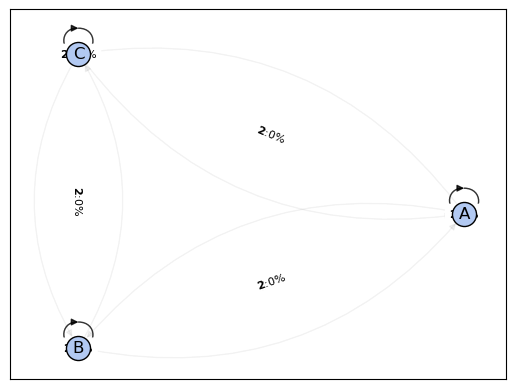

In [8]:
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph
graph = transition_matrix_to_graph(transition_matrix=process.transition_matrix,state_names=process.state_names_dict)
visualize_graph(graph, draw_mixed_state=True, layout='spectral')

# Computing the Mixed-State Presentation

The computation of the MSP from the process is in two steps:
1. Compute a tree of that keeps track of belief states as nodes, and emissions as edges. This is called a `MixedStateTree` and you can get it via `process.derive_mixed_state_presentation(depth=N)`, where N is the maximum length of sequences you want to consider.
2. Once we have a tree, we can then compute the MSP via `msp_tree.build_transition_graph()`. This returns a transition matrix which we can then use to create another `Process` using the `TransitionMatrixProcess` class.

We go through these steps and then visualize the MSP.

In [9]:
mixed_state_tree = process.derive_mixed_state_presentation(depth=train_config["n_ctx"] + 1)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

# Simplex Analysis

## Ground Truth Simplex

To get the ground truth simplex structure, we need to get all paths of any length on the mixed state tree, and their associated belief states. To do this, we use `mixed_state_tree.paths_and_belief_states`, which returns a list of tuples, where the first element is the path, and the second element is the belief state associated with it.



In [10]:
# in order to plot the belief states in the simplex, we need to get the paths and beliefs from the MSP
tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

# lets print out the first few paths and beliefs
for path, belief in zip(tree_paths[:5], tree_beliefs[:5]):
    print(f"Path: {''.join([str(x) for x in path])}, Belief: {belief}")

Path: 01010200022, Belief: [0.10622378 0.01589735 0.87787887]
Path: 01010200010, Belief: [0.92831617 0.05941184 0.01227199]
Path: 01010200011, Belief: [0.10672117 0.87728961 0.01598922]
Path: 01010200012, Belief: [0.2921145  0.21187898 0.49600652]
Path: 01010200000, Belief: [0.9893045  0.0053464  0.00534911]


In [11]:
# the MSP states are the unique beliefs in the tree
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
print(f"Number of Unique beliefs: {len(set(msp_beliefs))} out of {len(msp_beliefs)}")

Number of Unique beliefs: 237844 out of 265720


In [12]:
# now lets index each belief
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

for i in range(5):
    ith_belief = list(msp_belief_index.keys())[i]
    print(f"{ith_belief} is indexed as {msp_belief_index[ith_belief]}")

(0.19554, 0.57324, 0.23122) is indexed as 0
(0.43566, 0.05426, 0.51008) is indexed as 1
(0.03927, 0.05051, 0.91022) is indexed as 2
(0.06124, 0.92584, 0.01292) is indexed as 3
(0.02297, 0.01413, 0.96291) is indexed as 4


# Find Simplex in Transformer Activations

In [13]:
# now lets set up all the inputs as they arrive into the transformer
device = 'cpu'
transformer_inputs = [x for x in tree_paths if len(x) == train_config["n_ctx"]]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs[:5])

tensor([[2, 1, 1, 1, 1, 1, 0, 2, 2, 2],
        [2, 1, 1, 1, 1, 1, 0, 2, 2, 1],
        [2, 1, 1, 1, 1, 1, 0, 2, 2, 0],
        [0, 1, 0, 1, 0, 1, 2, 2, 2, 0],
        [0, 1, 0, 1, 0, 1, 2, 2, 2, 1]], dtype=torch.int32)


In [14]:
transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, tree_paths, tree_beliefs)

In [15]:
print(f"Transformer Input Beliefs: {transformer_input_beliefs.shape}, Transformer Input Belief Indices: {transformer_input_belief_indices.shape}")

Transformer Input Beliefs: torch.Size([59049, 10, 3]), Transformer Input Belief Indices: torch.Size([59049, 10])


In [16]:
_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
#_, activations = model.run_with_cache(transformer_inputs)
#activations['blocks.0.hook_resid_mid'].shape  'ln_final.hook_normalized'
#activations = activations['blocks.3.hook_resid_post']

In [17]:
activations.keys()

dict_keys(['blocks.0.hook_resid_pre', 'blocks.0.hook_resid_mid', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.hook_resid_mid', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'blocks.2.hook_resid_mid', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_pre', 'blocks.3.hook_resid_mid', 'blocks.3.hook_resid_post'])

In [18]:
# we now have activations [batch, n_ctx, d_model]
# and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
# and we have transformer_input_belief_indices [batch, n_ctx]

# in the end we want to do linear regression between the activations and the transformer_input_beliefs
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]
    
    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions



In [19]:
#acts = torch.concatenate((activations["blocks.0.ln1.hook_normalized"], activations["blocks.1.ln1.hook_normalized"], activations["blocks.2.ln1.hook_normalized"], activations["blocks.3.ln1.hook_normalized"]), dim=-1)
#acts = activations['ln_final.hook_normalized']
acts = activations['blocks.3.hook_resid_post']
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
print(belief_predictions.shape)



(59049, 10, 3)


# Plot of main result

/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_14147/3488364986.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


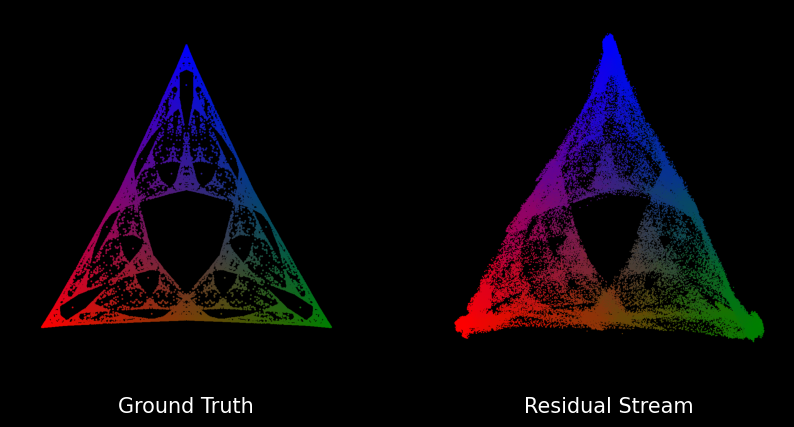

In [20]:
from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream
from epsilon_transformers.process.processes import Mess3
from epsilon_transformers.visualization.plots import plot_ground_truth_and_evaluated_2d_simplex


belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)
fig = plot_ground_truth_and_evaluated_2d_simplex(ground_truth_tensor=transformer_input_belief_flattened,
                                                 predicted_beliefs=belief_predictions_flattened,
                                                 plot_triangles=False, facecolor='black', px=1)

fig.show()



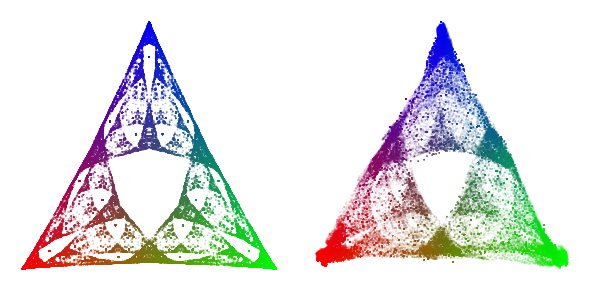

In [22]:
from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns
from matplotlib import pyplot as plt
# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

rgb_colors =  transformer_input_belief_flattened.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("paper")
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plotting the true beliefs projected onto the simplex
axes[0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.3)
axes[0].axis('off')

# Plotting the predicted beliefs projected onto the simplex
axes[1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01)
axes[1].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

# Plot of simplex through training

Loading model from 64000.pt
Loading model from 640000.pt
Loading model from 3187200.pt
Loading model from 629209600.pt


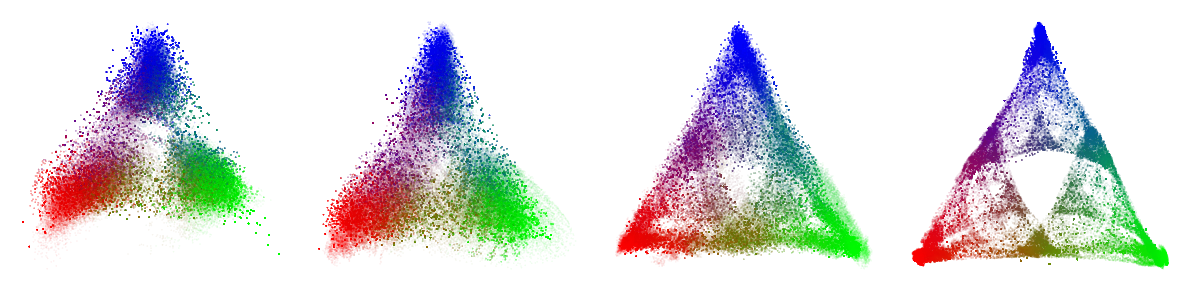

In [23]:

fig, axes = plt.subplots(1, 4, figsize=(3*4, 3))

for nt, ax in [(64000, axes[0]), (640000, axes[1]), (3187200, axes[2]), (629209600, axes[3])]:
    model_filename = f"{int(nt)}.pt"
    print(f"Loading model from {model_filename}")
    model = persister.load_model(object_name=model_filename, device='cpu')

    _, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
    acts = activations['blocks.3.hook_resid_post']
    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)

    belief_predictions_flattened = belief_predictions.reshape(-1, 3)
    transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)

    from epsilon_transformers.visualization.plots import _project_to_simplex
    import seaborn as sns
    # project to simplex
    belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
    belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

    rgb_colors =  transformer_input_belief_flattened.cpu().numpy()
    #rgb_colors = rgb_colors.astype(int)

    sns.set_context("paper")

    # Plotting the true beliefs projected onto the simplex
    #axes[0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
    #axes[0].axis('off')

    # Plotting the predicted beliefs projected onto the simplex
    ax.scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01)
    ax.axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the figure
plt.show()

# Plot of ground truth mess3 simplex

(-0.041188751161098484,
 1.0411837741732597,
 -0.037982575106434525,
 0.899374745762907)

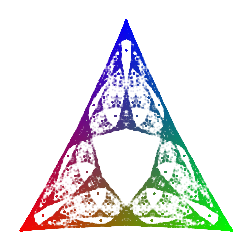

In [24]:
sns.set_context("paper")
fig, axes = plt.subplots(1, 1, figsize=(3, 3))

# Plotting the true beliefs projected onto the simplex
axes.scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
axes.axis('off')


# Plots of simplex controls

Loading model from 629209600.pt
torch.Size([47240, 10, 64])



/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_14147/633686220.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


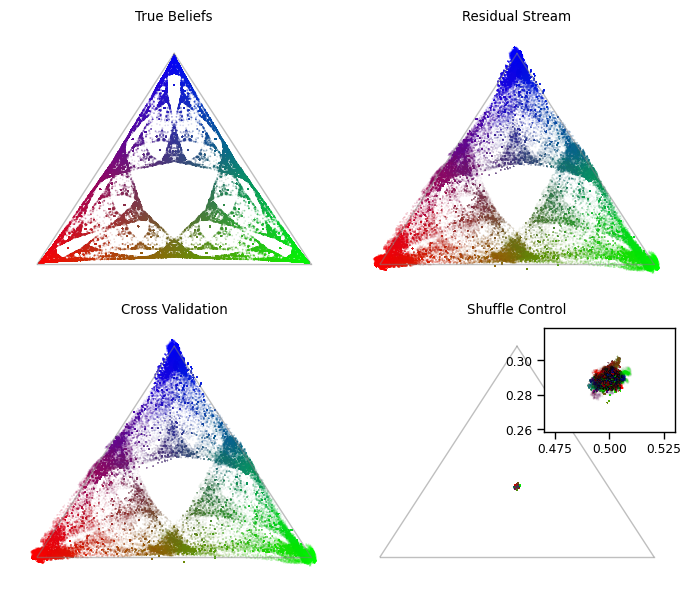

In [25]:
def shuffle_transformer_input_beliefs(transformer_input_beliefs):
    transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)
    transformer_input_belief_flattened_shuffled = transformer_input_belief_flattened.clone()
    transformer_input_belief_flattened_shuffled = transformer_input_belief_flattened_shuffled[torch.randperm(transformer_input_belief_flattened.shape[0])]
    transformer_input_beliefs_shuffled = transformer_input_belief_flattened_shuffled.reshape(transformer_input_beliefs.shape)
    return transformer_input_beliefs_shuffled


def train_test_split_transformer_input_beliefs(transformer_input_beliefs, acts, test_size=0.8):
    """
    Splits the transformer input beliefs and activations into train and test sets.
    
    Args:
    - transformer_input_beliefs (torch.Tensor): The input beliefs tensor. shape: [n_samples, n_ctx, 3]
    - acts (torch.Tensor): The activations tensor. shape: [n_samples, n_ctx, n_resid_dim]
    - test_size (float): The proportion of the data to include in the test split.
    
    Returns:
    - transformer_input_beliefs_train (torch.Tensor): The training set of beliefs. shape: [n_train_samples, n_ctx, 3]
    - transformer_input_beliefs_test (torch.Tensor): The test set of beliefs. shape: [n_test_samples, n_ctx, 3]
    - act_train (torch.Tensor): The training set of activations. shape: [n_train_samples, n_ctx, n_resid_dim]
    - act_test (torch.Tensor): The test set of activations. shape: [n_test_samples, n_ctx, n_resid_dim]
    - rgb_colors_train (numpy.ndarray): The training set of RGB colors.
    - rgb_colors_test (numpy.ndarray): The test set of RGB colors.
    """
    # Calculate the number of samples and dimensions
    n_samples, n_ctx, _ = transformer_input_beliefs.shape
    _, _, n_resid_dim = acts.shape
    
    # Generate random indices and split into train/test sets
    indices = torch.randperm(n_samples)
    train_size = int((1 - test_size) * n_samples)
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    # Split the tensors into train and test sets
    transformer_input_beliefs_train = transformer_input_beliefs[train_indices]
    transformer_input_beliefs_test = transformer_input_beliefs[test_indices]
    act_train = acts[train_indices]
    act_test = acts[test_indices]
    
    return transformer_input_beliefs_train, transformer_input_beliefs_test, act_train, act_test


from mpl_toolkits.axes_grid1.inset_locator import inset_axes

transformer_input_beliefs_shuffled = shuffle_transformer_input_beliefs(transformer_input_beliefs)

fig, axes = plt.subplots(2, 2, figsize=(7, 6))

# make the simplex for the lowest loss network
nt = 629209600
model_filename = f"{int(nt)}.pt"
print(f"Loading model from {model_filename}")
model = persister.load_model(object_name=model_filename, device='cpu')

_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
acts = activations['blocks.3.hook_resid_post']

regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
shuffled_regression, shuffled_belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs_shuffled)

transformer_input_beliefs_train, transformer_input_beliefs_test, act_train, act_test = train_test_split_transformer_input_beliefs(transformer_input_beliefs, acts)
regression_cv, _ = run_activation_to_beliefs_regression(act_train, transformer_input_beliefs_train)

# run regression_cv on held out data
print(act_test.shape)
belief_predictions_cv = regression_cv.predict(act_test.reshape(-1, act_test.shape[-1]))
print()

belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)
belief_predictions_shuffled_flattened = shuffled_belief_predictions.reshape(-1, 3)
belief_predictions_cv_flattened = belief_predictions_cv.reshape(-1, 3)

from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns
# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)
belief_pred_projected_shuffled = _project_to_simplex(belief_predictions_shuffled_flattened)
belief_pred_projected_cv = _project_to_simplex(belief_predictions_cv_flattened)

rgb_colors =  transformer_input_belief_flattened.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("paper")

def plot_eq_triangle(ax, points, color='black', linewidth=1, alpha=0.5):
    # Draw lines between the points to form the triangle
    ax.plot([points[0][0], points[1][0]], [points[0][1], points[1][1]], color=color, linewidth=linewidth, alpha=alpha)
    ax.plot([points[1][0], points[2][0]], [points[1][1], points[2][1]], color=color, linewidth=linewidth, alpha=alpha)
    ax.plot([points[2][0], points[0][0]], [points[2][1], points[0][1]], color=color, linewidth=linewidth, alpha=alpha)

def set_lims(ax):
    ax.axis('off')
    x_lim = [0-eps, 1+eps]
    y_lim = [0-eps, np.sqrt(3)/2+eps]
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

eps = 0.1
x_lim = [0-eps, 1+eps]
y_lim = [0-eps, np.sqrt(3)/2+eps]
triangle_points = [[0, 0], [1, 0], [0.5, np.sqrt(3)/2]]

# Plotting the true beliefs projected onto the simplex
plot_eq_triangle(axes[0,0], triangle_points, color='gray', linewidth=1)
axes[0,0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
axes[0,0].set_title("True Beliefs")
set_lims(axes[0,0])

# Plotting the predicted beliefs projected onto the simplex
plot_eq_triangle(axes[0,1], triangle_points, color='gray', linewidth=1)
axes[0,1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01)
axes[0,1].set_title("Residual Stream")
set_lims(axes[0,1])

# Plotting the cross-validated beliefs projected onto the simplex
plot_eq_triangle(axes[1,0], triangle_points, color='gray', linewidth=1)
colors_cv = transformer_input_beliefs_test.cpu().numpy().reshape(-1, 3)
axes[1,0].scatter(belief_pred_projected_cv[0], belief_pred_projected_cv[1], marker='.', c=colors_cv, alpha=0.5, s=0.01)
axes[1,0].set_title("Cross Validation")
set_lims(axes[1,0])

# Plotting the shuffled control beliefs projected onto the simplex
plot_eq_triangle(axes[1,1], triangle_points, color='gray', linewidth=1)
axes[1,1].scatter(belief_pred_projected_shuffled[0], belief_pred_projected_shuffled[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01)
axes[1,1].set_title("Shuffle Control")
set_lims(axes[1,1])

# Create an inset in the last subplot
ax_inset = inset_axes(axes[1, 1], width="40%", height="40%", loc='upper right')

# Set the limits for the inset to zoom into the desired region
com = np.mean(belief_pred_projected_shuffled, axis=1)
com_eps = 0.03
x1, x2, y1, y2 = com[0] - com_eps, com[0] + com_eps, com[1] - com_eps, com[1] + com_eps
ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)

# Plot the zoomed-in data in the inset
ax_inset.scatter(belief_pred_projected_shuffled[0], belief_pred_projected_shuffled[1], marker='.', c=rgb_colors, alpha=0.1, s=0.01)
#plot_eq_triangle(ax_inset, triangle_points, color='gray', linewidth=1)

# Optionally, remove the axis for the inset to keep it clean
ax_inset.axis('on')


# Adjust layout for better spacing
plt.tight_layout()

# Compute MSE of regression with controls

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns
from tqdm import tqdm

# Function to calculate mean squared error
def calculate_error(true_beliefs, predicted_beliefs):
    return ((true_beliefs - predicted_beliefs) ** 2).mean()

def run_cross_validation(transformer_input_beliefs, acts, N_cross):
    errors_cv = []
    for _ in tqdm(range(N_cross), desc="Cross Validation"):
        transformer_input_beliefs_train, transformer_input_beliefs_test, act_train, act_test = train_test_split_transformer_input_beliefs(transformer_input_beliefs, acts)
        regression_cv, _ = run_activation_to_beliefs_regression(act_train, transformer_input_beliefs_train)
        belief_predictions_cv = regression_cv.predict(act_test.reshape(-1, act_test.shape[-1])).reshape(transformer_input_beliefs_test.shape)
        error_cv = calculate_error(transformer_input_beliefs_test, belief_predictions_cv)
        errors_cv.append(error_cv.item())  # Convert tensor to float
    return errors_cv

def run_shuffle_procedure(transformer_input_beliefs, acts, N_shuff):
    errors_shuff = []
    for _ in tqdm(range(N_shuff), desc="Shuffle Procedure"):
        transformer_input_beliefs_shuffled = shuffle_transformer_input_beliefs(transformer_input_beliefs)
        shuffled_regression, shuffled_belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs_shuffled)
        error_shuff = calculate_error(transformer_input_beliefs, shuffled_belief_predictions)
        errors_shuff.append(error_shuff.item())  # Convert tensor to float
    return errors_shuff

# Running the procedures and collecting errors
N_cross = 1000
N_shuff = 1000

transformer_input_beliefs_shuffled = shuffle_transformer_input_beliefs(transformer_input_beliefs)

# make the simplex for the lowest loss network
nt = 629209600
model_filename = f"{int(nt)}.pt"
print(f"Loading model from {model_filename}")
model = persister.load_model(object_name=model_filename, device='cpu')

_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
acts = activations['blocks.3.hook_resid_post']

# Original regression
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
error_residual = calculate_error(transformer_input_beliefs, belief_predictions).item()  # Convert tensor to float

# Cross-validation errors
errors_cv = run_cross_validation(transformer_input_beliefs, acts, N_cross)

# Shuffle errors
errors_shuff = run_shuffle_procedure(transformer_input_beliefs, acts, N_shuff)

# Plotting the errors
error_labels = ['Residual Stream'] + ['Cross Validation']*N_cross + ['Shuffle Control']*N_shuff
error_values = [error_residual] + errors_cv + errors_shuff


Loading model from 629209600.pt


python(14305) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Shuffle Procedure: 100%|██████████| 1000/1000 [11:38<00:00,  1.43it/s]


In [28]:

for nt in [64000, 640000, 3187200, 629209600]:
    model_filename = f"{int(nt)}.pt"
    print(f"Loading model from {model_filename}")
    model = persister.load_model(object_name=model_filename, device='cpu')

    _, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
    acts = activations['blocks.3.hook_resid_post']
    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)

    error_residual = calculate_error(transformer_input_beliefs, belief_predictions).item()  # Convert tensor to float
    print(f"Error for model {model_filename}: {error_residual}")


Loading model from 64000.pt
Error for model 64000.pt: 0.011824862100183964
Loading model from 640000.pt
Error for model 640000.pt: 0.008408287540078163
Loading model from 3187200.pt
Error for model 3187200.pt: 0.0024808391463011503
Loading model from 629209600.pt
Error for model 629209600.pt: 0.00038635320379398763


# Figure 6 recreation

Loading model from 6400.pt
Loading model from 915200.pt
Loading model from 3187200.pt
Loading model from 629209600.pt


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_14147/415785297.py:159: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(y=[f"{nt}" for nt in model_checkpoints], x=errors, ci='sd', ax=ax_new)  # Add error bars with standard deviation
/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


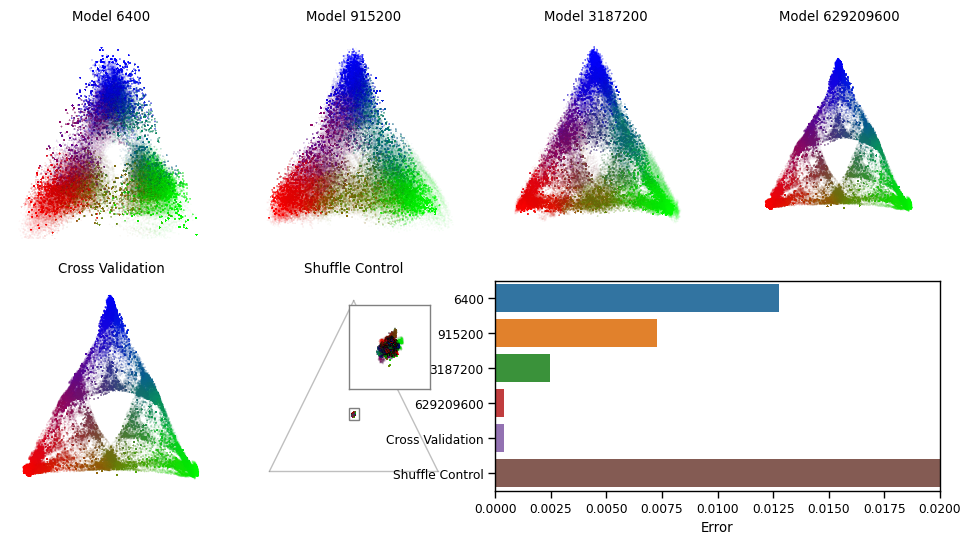

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

traingle_padding = 0.1
xlims = [-traingle_padding, 1 + traingle_padding]
ylims = [-traingle_padding, (3**0.5) / 2 + traingle_padding]

sns.set_context("paper")

def shuffle_transformer_input_beliefs(transformer_input_beliefs):
    transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)
    transformer_input_belief_flattened_shuffled = transformer_input_belief_flattened.clone()
    transformer_input_belief_flattened_shuffled = transformer_input_belief_flattened_shuffled[torch.randperm(transformer_input_belief_flattened.shape[0])]
    transformer_input_beliefs_shuffled = transformer_input_belief_flattened_shuffled.reshape(transformer_input_beliefs.shape)
    return transformer_input_beliefs_shuffled


def train_test_split_transformer_input_beliefs(transformer_input_beliefs, acts, test_size=0.8):
    """
    Splits the transformer input beliefs and activations into train and test sets.
    
    Args:
    - transformer_input_beliefs (torch.Tensor): The input beliefs tensor. shape: [n_samples, n_ctx, 3]
    - acts (torch.Tensor): The activations tensor. shape: [n_samples, n_ctx, n_resid_dim]
    - test_size (float): The proportion of the data to include in the test split.
    
    Returns:
    - transformer_input_beliefs_train (torch.Tensor): The training set of beliefs. shape: [n_train_samples, n_ctx, 3]
    - transformer_input_beliefs_test (torch.Tensor): The test set of beliefs. shape: [n_test_samples, n_ctx, 3]
    - act_train (torch.Tensor): The training set of activations. shape: [n_train_samples, n_ctx, n_resid_dim]
    - act_test (torch.Tensor): The test set of activations. shape: [n_test_samples, n_ctx, n_resid_dim]
    - rgb_colors_train (numpy.ndarray): The training set of RGB colors.
    - rgb_colors_test (numpy.ndarray): The test set of RGB colors.
    """
    # Calculate the number of samples and dimensions
    n_samples, n_ctx, _ = transformer_input_beliefs.shape
    _, _, n_resid_dim = acts.shape
    
    # Generate random indices and split into train/test sets
    indices = torch.randperm(n_samples)
    train_size = int((1 - test_size) * n_samples)
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    # Split the tensors into train and test sets
    transformer_input_beliefs_train = transformer_input_beliefs[train_indices]
    transformer_input_beliefs_test = transformer_input_beliefs[test_indices]
    act_train = acts[train_indices]
    act_test = acts[test_indices]
    
    return transformer_input_beliefs_train, transformer_input_beliefs_test, act_train, act_test


# Function to load model, run analysis, and calculate error
def load_model_and_calculate_error(nt):
    model_filename = f"{int(nt)}.pt"
    print(f"Loading model from {model_filename}")
    model = persister.load_model(object_name=model_filename, device='cpu')
    _, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
    acts = activations['blocks.3.hook_resid_post']
    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
    error_residual = calculate_error(transformer_input_beliefs, belief_predictions).item()  # Convert tensor to float
    belief_predictions_projected = _project_to_simplex(belief_predictions)
    return error_residual, belief_predictions_projected

def load_model_and_run_analysis(nt):
    model_filename = f"{int(nt)}.pt"
    print(f"Loading model from {model_filename}")
    model = persister.load_model(object_name=model_filename, device='cpu')
    _, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
    acts = activations['blocks.3.hook_resid_post']
    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
    error_residual = calculate_error(transformer_input_beliefs, belief_predictions).item()  # Convert tensor to float
    belief_pred_projected = _project_to_simplex(belief_predictions.reshape(-1, 3))
    return error_residual, belief_pred_projected
    
# List of model checkpoints
model_checkpoints = [6400, #64000, 217600, 
                        915200, 3187200, 629209600]

# Collect errors and belief predictions
errors = []
belief_predictions_list = []
for nt in model_checkpoints:
    error, belief_predictions_projected = load_model_and_run_analysis(nt)
    errors.append(error)
    belief_predictions_list.append(belief_predictions_projected)

# Create figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Adjusted to have 6 columns



# Plot scatter plots for each model
for i, (nt, belief_predictions_projected) in enumerate(zip(model_checkpoints, belief_predictions_list)):
    row = i // 4
    col = i % 4
    axes[row, col].scatter(belief_predictions_projected[0], belief_predictions_projected[1], marker='.', c=rgb_colors, alpha=0.3, s=0.01, rasterized=True)
    axes[row, col].set_xlim(xlims[0] - 0.1 * (xlims[1] - xlims[0]), xlims[1] + 0.1 * (xlims[1] - xlims[0]))
    axes[row, col].set_ylim(ylims[0] - 0.1 * (ylims[1] - ylims[0]), ylims[1] + 0.1 * (ylims[1] - ylims[0]))
    axes[row, col].set_title(f'Model {nt}')



# Plotting the cross-validated beliefs projected onto the simplex
#plot_eq_triangle(axes[1,0], triangle_points, color='gray', linewidth=1)
colors_cv = transformer_input_beliefs_test.cpu().numpy().reshape(-1, 3)
axes[1,0].scatter(belief_pred_projected_cv[0], belief_pred_projected_cv[1], marker='.', c=colors_cv, alpha=0.5, s=0.01, rasterized=True)
axes[1,0].set_title("Cross Validation")
set_lims(axes[1,0])

# Plotting the shuffled control beliefs projected onto the simplex
plot_eq_triangle(axes[1,1], triangle_points, color='gray', linewidth=1)
axes[1,1].scatter(belief_pred_projected_shuffled[0], belief_pred_projected_shuffled[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01, rasterized=True)
axes[1,1].set_title("Shuffle Control")
set_lims(axes[1,1])

# Create an inset in the last subplot
ax_inset = inset_axes(axes[1, 1], width="40%", height="40%", loc='upper right', borderpad=2)

# Set the limits for the inset to zoom into the desired region
com = np.mean(belief_pred_projected_shuffled, axis=1)
com_eps = 0.03
x1, x2, y1, y2 = com[0] - com_eps, com[0] + com_eps, com[1] - com_eps, com[1] + com_eps
ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)

# Plot the zoomed-in data in the inset
ax_inset.scatter(belief_pred_projected_shuffled[0], belief_pred_projected_shuffled[1], marker='.', c=rgb_colors, alpha=0.1, s=0.01, rasterized=True)

# Remove the ticks and labels on the inset
ax_inset.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add a greyed-out box around the inset
for spine in ax_inset.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1.0)

# Add a corresponding box on the main plot to indicate the zoomed-in region
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.0, edgecolor='gray', facecolor='none', linestyle='-')
axes[1, 1].add_patch(rect)

model_checkpoints.extend(['Cross Validation', 'Shuffle Control'])
errors.extend([np.mean(errors_cv), np.mean(errors_shuff)])
# Create bar plot

# Merge the axes[1, 2] and axes[1, 3] to create a single subplot spanning both columns
from matplotlib.gridspec import GridSpec

# Remove the original axes[1, 3]
fig.delaxes(axes[1, 3])

# Create a new axis that spans both columns
gs = GridSpec(2, 4, figure=fig)
ax_new = fig.add_subplot(gs[1, 2:4])

# Create the horizontal bar plot
sns.barplot(y=[f"{nt}" for nt in model_checkpoints], x=errors, ci='sd', ax=ax_new)  # Add error bars with standard deviation
ax_new.set_xlabel('Error')
ax_new.set_yticklabels(ax_new.get_yticklabels(), rotation=0)  # Ensure y labels are horizontal
ax_new.set_xlim(0, 0.02)

# Hide unused subplots
for j in range(0, 3):
    axes[0, j].axis('off')
    axes[1, j].axis('off')
axes[0,3].axis('off')
# Adjust layout for better spacing
#plt.tight_layout()

plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Arial'
plt.savefig('mess3_simplex_details.pdf', format='pdf')


Loading model from 6400.pt
Loading model from 915200.pt
Loading model from 3187200.pt
Loading model from 629209600.pt


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_14147/3245852606.py:153: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(y=[f"{nt}" for nt in model_checkpoints], x=errors, ci='sd', ax=ax_new)  # Add error bars with standard deviation
/Users/adamimos/anaconda3/envs/epsilon-machine/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


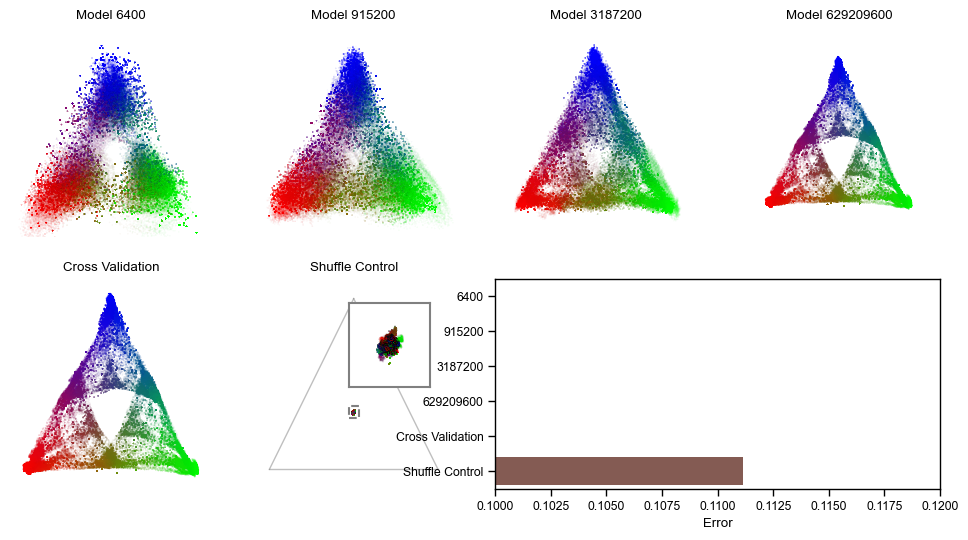

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper")

def shuffle_transformer_input_beliefs(transformer_input_beliefs):
    transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)
    transformer_input_belief_flattened_shuffled = transformer_input_belief_flattened.clone()
    transformer_input_belief_flattened_shuffled = transformer_input_belief_flattened_shuffled[torch.randperm(transformer_input_belief_flattened.shape[0])]
    transformer_input_beliefs_shuffled = transformer_input_belief_flattened_shuffled.reshape(transformer_input_beliefs.shape)
    return transformer_input_beliefs_shuffled


def train_test_split_transformer_input_beliefs(transformer_input_beliefs, acts, test_size=0.8):
    """
    Splits the transformer input beliefs and activations into train and test sets.
    
    Args:
    - transformer_input_beliefs (torch.Tensor): The input beliefs tensor. shape: [n_samples, n_ctx, 3]
    - acts (torch.Tensor): The activations tensor. shape: [n_samples, n_ctx, n_resid_dim]
    - test_size (float): The proportion of the data to include in the test split.
    
    Returns:
    - transformer_input_beliefs_train (torch.Tensor): The training set of beliefs. shape: [n_train_samples, n_ctx, 3]
    - transformer_input_beliefs_test (torch.Tensor): The test set of beliefs. shape: [n_test_samples, n_ctx, 3]
    - act_train (torch.Tensor): The training set of activations. shape: [n_train_samples, n_ctx, n_resid_dim]
    - act_test (torch.Tensor): The test set of activations. shape: [n_test_samples, n_ctx, n_resid_dim]
    - rgb_colors_train (numpy.ndarray): The training set of RGB colors.
    - rgb_colors_test (numpy.ndarray): The test set of RGB colors.
    """
    # Calculate the number of samples and dimensions
    n_samples, n_ctx, _ = transformer_input_beliefs.shape
    _, _, n_resid_dim = acts.shape
    
    # Generate random indices and split into train/test sets
    indices = torch.randperm(n_samples)
    train_size = int((1 - test_size) * n_samples)
    
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    # Split the tensors into train and test sets
    transformer_input_beliefs_train = transformer_input_beliefs[train_indices]
    transformer_input_beliefs_test = transformer_input_beliefs[test_indices]
    act_train = acts[train_indices]
    act_test = acts[test_indices]
    
    return transformer_input_beliefs_train, transformer_input_beliefs_test, act_train, act_test


# Function to load model, run analysis, and calculate error
def load_model_and_calculate_error(nt):
    model_filename = f"{int(nt)}.pt"
    print(f"Loading model from {model_filename}")
    model = persister.load_model(object_name=model_filename, device='cpu')
    _, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
    acts = activations['blocks.3.hook_resid_post']
    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
    error_residual = calculate_error(transformer_input_beliefs, belief_predictions).item()  # Convert tensor to float
    belief_predictions_projected = _project_to_simplex(belief_predictions)
    return error_residual, belief_predictions_projected

def load_model_and_run_analysis(nt):
    model_filename = f"{int(nt)}.pt"
    print(f"Loading model from {model_filename}")
    model = persister.load_model(object_name=model_filename, device='cpu')
    _, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
    acts = activations['blocks.3.hook_resid_post']
    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
    error_residual = calculate_error(transformer_input_beliefs, belief_predictions).item()  # Convert tensor to float
    belief_pred_projected = _project_to_simplex(belief_predictions.reshape(-1, 3))
    return error_residual, belief_pred_projected
    
# List of model checkpoints
model_checkpoints = [6400, #64000, 217600, 
                        915200, 3187200, 629209600]

# Collect errors and belief predictions
errors = []
belief_predictions_list = []
for nt in model_checkpoints:
    error, belief_predictions_projected = load_model_and_run_analysis(nt)
    errors.append(error)
    belief_predictions_list.append(belief_predictions_projected)

# Create figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Adjusted to have 6 columns

# Plot scatter plots for each model
for i, (nt, belief_predictions_projected) in enumerate(zip(model_checkpoints, belief_predictions_list)):
    row = i // 4
    col = i % 4
    axes[row, col].scatter(belief_predictions_projected[0], belief_predictions_projected[1], marker='.', c=rgb_colors, alpha=0.3, s=0.01, rasterized=True)
    axes[row, col].set_xlim(xlims[0] - 0.1 * (xlims[1] - xlims[0]), xlims[1] + 0.1 * (xlims[1] - xlims[0]))
    axes[row, col].set_ylim(ylims[0] - 0.1 * (ylims[1] - ylims[0]), ylims[1] + 0.1 * (ylims[1] - ylims[0]))
    axes[row, col].set_title(f'Model {nt}')



# Plotting the cross-validated beliefs projected onto the simplex
#plot_eq_triangle(axes[1,0], triangle_points, color='gray', linewidth=1)
colors_cv = transformer_input_beliefs_test.cpu().numpy().reshape(-1, 3)
axes[1,0].scatter(belief_pred_projected_cv[0], belief_pred_projected_cv[1], marker='.', c=colors_cv, alpha=0.5, s=0.01, rasterized=True)
axes[1,0].set_title("Cross Validation")
set_lims(axes[1,0])

# Plotting the shuffled control beliefs projected onto the simplex
plot_eq_triangle(axes[1,1], triangle_points, color='gray', linewidth=1)
axes[1,1].scatter(belief_pred_projected_shuffled[0], belief_pred_projected_shuffled[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01, rasterized=True)
axes[1,1].set_title("Shuffle Control")
set_lims(axes[1,1])

# Create an inset in the last subplot
ax_inset = inset_axes(axes[1, 1], width="40%", height="40%", loc='upper right', borderpad=2)

# Set the limits for the inset to zoom into the desired region
com = np.mean(belief_pred_projected_shuffled, axis=1)
com_eps = 0.03
x1, x2, y1, y2 = com[0] - com_eps, com[0] + com_eps, com[1] - com_eps, com[1] + com_eps
ax_inset.set_xlim(x1, x2)
ax_inset.set_ylim(y1, y2)

# Plot the zoomed-in data in the inset
ax_inset.scatter(belief_pred_projected_shuffled[0], belief_pred_projected_shuffled[1], marker='.', c=rgb_colors, alpha=0.1, s=0.01, rasterized=True)

# Remove the ticks and labels on the inset
ax_inset.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Add a greyed-out box around the inset
for spine in ax_inset.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(1.5)

# Add a corresponding box on the main plot to indicate the zoomed-in region
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1.5, edgecolor='gray', facecolor='none', linestyle='--')
axes[1, 1].add_patch(rect)

model_checkpoints.extend(['Cross Validation', 'Shuffle Control'])
errors.extend([np.mean(errors_cv), np.mean(errors_shuff)])
# Create bar plot

# Merge the axes[1, 2] and axes[1, 3] to create a single subplot spanning both columns
from matplotlib.gridspec import GridSpec

# Remove the original axes[1, 3]
fig.delaxes(axes[1, 3])

# Create a new axis that spans both columns
gs = GridSpec(2, 4, figure=fig)
ax_new = fig.add_subplot(gs[1, 2:4])

# Create the horizontal bar plot
sns.barplot(y=[f"{nt}" for nt in model_checkpoints], x=errors, ci='sd', ax=ax_new)  # Add error bars with standard deviation
ax_new.set_xlabel('Error')
ax_new.set_yticklabels(ax_new.get_yticklabels(), rotation=0)  # Ensure y labels are horizontal
top = .12
ax_new.set_xlim(top-0.02, top)

# Hide unused subplots
for j in range(0, 3):
    axes[0, j].axis('off')
    axes[1, j].axis('off')
axes[0,3].axis('off')
# Adjust layout for better spacing
#plt.tight_layout()



plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('mess3_simplex_details_zoom.pdf', format='pdf')

In [31]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from epsilon_transformers.visualization.plots import _project_to_simplex

def compute_analysis(transformer_input_beliefs, transformer_inputs, persister, shuffle_transformer_input_beliefs, run_activation_to_beliefs_regression, train_test_split_transformer_input_beliefs):
    transformer_input_beliefs_shuffled = shuffle_transformer_input_beliefs(transformer_input_beliefs)

    fig, axes = plt.subplots(2, 2, figsize=(7, 6))

    # make the simplex for the lowest loss network
    nt = 629209600
    model_filename = f"{int(nt)}.pt"
    print(f"Loading model from {model_filename}")
    model = persister.load_model(object_name=model_filename, device='cpu')

    _, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
    acts = activations['blocks.3.hook_resid_post']

    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
    shuffled_regression, shuffled_belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs_shuffled)

    transformer_input_beliefs_train, transformer_input_beliefs_test, act_train, act_test = train_test_split_transformer_input_beliefs(transformer_input_beliefs, acts)
    regression_cv, _ = run_activation_to_beliefs_regression(act_train, transformer_input_beliefs_train)

    # run regression_cv on held out data
    print(act_test.shape)
    belief_predictions_cv = regression_cv.predict(act_test.reshape(-1, act_test.shape[-1]))
    print()

    belief_predictions_flattened = belief_predictions.reshape(-1, 3)
    transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)
    belief_predictions_shuffled_flattened = shuffled_belief_predictions.reshape(-1, 3)
    belief_predictions_cv_flattened = belief_predictions_cv.reshape(-1, 3)

    # project to simplex
    belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
    belief_pred_projected = _project_to_simplex(belief_predictions_flattened)
    belief_pred_projected_shuffled = _project_to_simplex(belief_predictions_shuffled_flattened)
    belief_pred_projected_cv = _project_to_simplex(belief_predictions_cv_flattened)

    rgb_colors = transformer_input_belief_flattened.cpu().numpy()

    sns.set_context("paper")

    def plot_eq_triangle(ax, points, color='black', linewidth=1, alpha=0.5):
        # Draw lines between the points to form the triangle
        ax.plot([points[0][0], points[1][0]], [points[0][1], points[1][1]], color=color, linewidth=linewidth, alpha=alpha)
        ax.plot([points[1][0], points[2][0]], [points[1][1], points[2][1]], color=color, linewidth=linewidth, alpha=alpha)
        ax.plot([points[2][0], points[0][0]], [points[2][1], points[0][1]], color=color, linewidth=linewidth, alpha=alpha)

    def set_lims(ax):
        ax.axis('off')
        x_lim = [0-eps, 1+eps]
        y_lim = [0-eps, np.sqrt(3)/2+eps]
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)

    eps = 0.1
    x_lim = [0-eps, 1+eps]
    y_lim = [0-eps, np.sqrt(3)/2+eps]
    triangle_points = [[0, 0], [1, 0], [0.5, np.sqrt(3)/2]]

    # Plotting the true beliefs projected onto the simplex
    plot_eq_triangle(axes[0,0], triangle_points, color='gray', linewidth=1)
    axes[0,0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
    axes[0,0].set_title("True Beliefs")
    set_lims(axes[0,0])

    # Plotting the predicted beliefs projected onto the simplex
    plot_eq_triangle(axes[0,1], triangle_points, color='gray', linewidth=1)
    axes[0,1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01)
    axes[0,1].set_title("Residual Stream")
    set_lims(axes[0,1])

    # Plotting the cross-validated beliefs projected onto the simplex
    plot_eq_triangle(axes[1,0], triangle_points, color='gray', linewidth=1)
    colors_cv = transformer_input_beliefs_test.cpu().numpy().reshape(-1, 3)
    axes[1,0].scatter(belief_pred_projected_cv[0], belief_pred_projected_cv[1], marker='.', c=colors_cv, alpha=0.5, s=0.01)
    axes[1,0].set_title("Cross Validation")
    set_lims(axes[1,0])

    # Plotting the shuffled control beliefs projected onto the simplex
    plot_eq_triangle(axes[1,1], triangle_points, color='gray', linewidth=1)
    axes[1,1].scatter(belief_pred_projected_shuffled[0], belief_pred_projected_shuffled[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01)
    axes[1,1].set_title("Shuffle Control")
    set_lims(axes[1,1])

    # Create an inset in the last subplot
    ax_inset = inset_axes(axes[1, 1], width="40%", height="40%", loc='upper right')

    # Set the limits for the inset to zoom into the desired region
    com = np.mean(belief_pred_projected_shuffled, axis=1)
    com_eps = 0.03
    x1, x2, y1, y2 = com[0] - com_eps, com[0] + com_eps, com[1] - com_eps, com[1] + com_eps
    ax_inset.set_xlim(x1, x2)
    ax_inset.set_ylim(y1, y2)

    # Plot the zoomed-in data in the inset
    ax_inset.scatter(belief_pred_projected_shuffled[0], belief_pred_projected_shuffled[1], marker='.', c=rgb_colors, alpha=0.1, s=0.01)
    #plot_eq_triangle(ax_inset, triangle_points, color='gray', linewidth=1)

    # Optionally, remove the axis for the inset to keep it clean
    ax_inset.axis('on')

    # Adjust layout for better spacing
    plt.tight_layout()

# Example usage:
# compute_analysis(transformer_input_beliefs, transformer_inputs, persister, shuffle_transformer_input_beliefs, run_activation_to_beliefs_regression, train_test_split_transformer_input_beliefs)


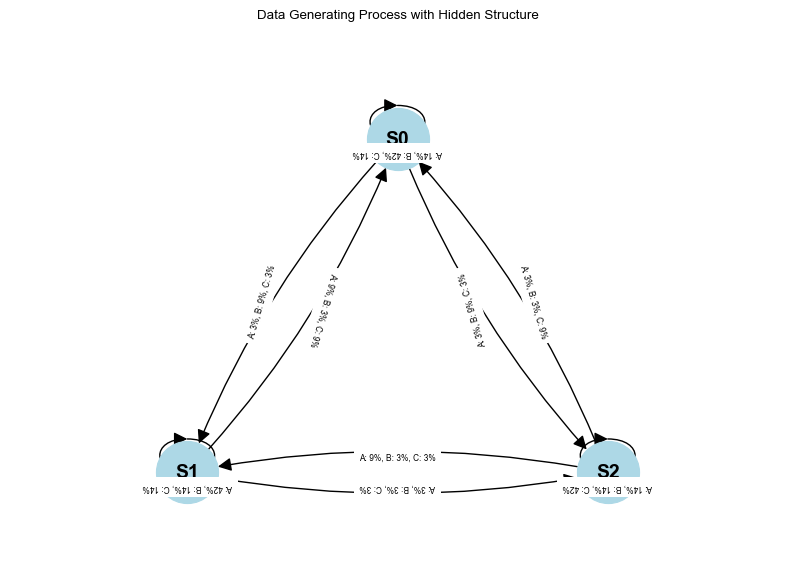

In [32]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(ax, curve=0.2):
    # Define the graph structure with curved edges
    edges = [
        ('S1', 'S1', 'A: 42%, B: 14%, C: 14%'),
        ('S1', 'S0', 'A: 9%, B: 3%, C: 9%'),
        ('S1', 'S2', 'A: 3%, B: 3%, C: 3%'),
        ('S0', 'S0', 'A: 14%, B: 42%, C: 14%'),
        ('S0', 'S2', 'A: 3%, B: 9%, C: 3%'),
        ('S0', 'S1', 'A: 3%, B: 9%, C: 3%'),
        ('S2', 'S2', 'A: 14%, B: 14%, C: 42%'),
        ('S2', 'S1', 'A: 9%, B: 3%, C: 3%'),
        ('S2', 'S0', 'A: 3%, B: 3%, C: 9%')
    ]

    G = nx.DiGraph()
    for edge in edges:
        G.add_edge(edge[0], edge[1], label=edge[2])

    # Define node positions on an equilateral triangle
    pos = {'S0': (0, np.sqrt(3)/2), 'S1': (-0.5, -np.sqrt(3)/2), 'S2': (0.5, -np.sqrt(3)/2)}

    # Draw the graph on the provided axis
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=14, font_weight='bold', connectionstyle=f'arc3, rad={curve}', arrowsize=20, ax=ax)
    edge_labels = nx.get_edge_attributes(G, 'label')
    for (n1, n2), label in edge_labels.items():
        x1, y1 = pos[n1]
        x2, y2 = pos[n2]
        offset = 0.075  # Adjust this value to control the offset distance
        dx = x2 - x1
        dy = y2 - y1
        angle = np.arctan2(dy, dx)
        x_offset = offset * np.sin(angle)
        y_offset = -offset * np.cos(angle)
        pos_label = ((x1 + x2) / 2 + x_offset, (y1 + y2) / 2 + y_offset)
        ax.text(pos_label[0], pos_label[1], label, fontsize=6, ha='center', va='center', 
                bbox=dict(facecolor='white', edgecolor='none', alpha=1.0), rotation=np.degrees(angle) + 180, rotation_mode='anchor')
    
    # Add padding around the plot to make it look smaller
    padd_amount = 0.3
    current_xlim = ax.get_xlim()
    current_ylim = ax.get_ylim()
    ax.set_xlim(current_xlim[0] - padd_amount, current_xlim[1] + padd_amount)
    ax.set_ylim(current_ylim[0] - padd_amount, current_ylim[1] + padd_amount)
    
    ax.set_title('Data Generating Process with Hidden Structure')

# Example usage with subplots
fig, ax = plt.subplots(figsize=(10, 7))
plot_graph(ax, curve=0.1)
# save as mess3 process. use sans serif as fonts
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.savefig('mess3_process.pdf', format='pdf')
plt.show()


Loading model from 629209600.pt


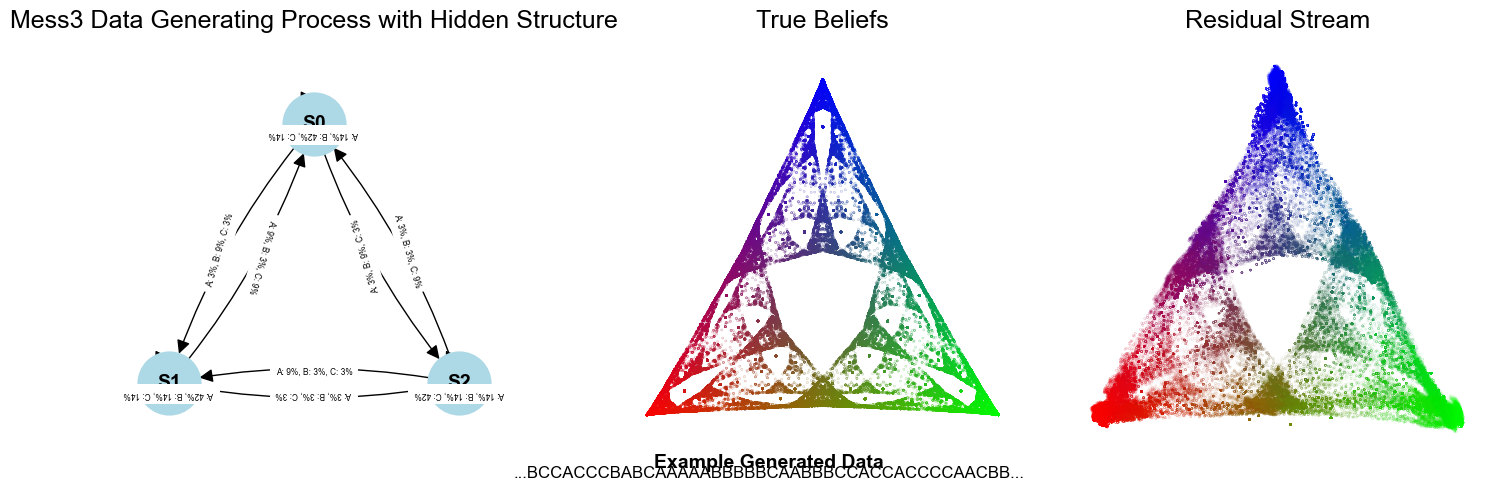

In [33]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# make the simplex for the lowest loss network
nt = 629209600
model_filename = f"{int(nt)}.pt"
print(f"Loading model from {model_filename}")
model = persister.load_model(object_name=model_filename, device='cpu')

_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid' in x)
acts = activations['blocks.3.hook_resid_post']

regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)

belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)

from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns
# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

rgb_colors = transformer_input_belief_flattened.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("talk")

def plot_eq_triangle(ax, points, color='black', linewidth=1, alpha=0.5):
    # Draw lines between the points to form the triangle
    ax.plot([points[0][0], points[1][0]], [points[0][1], points[1][1]], color=color, linewidth=linewidth, alpha=alpha)
    ax.plot([points[1][0], points[2][0]], [points[1][1], points[2][1]], color=color, linewidth=linewidth, alpha=alpha)
    ax.plot([points[2][0], points[0][0]], [points[2][1], points[0][1]], color=color, linewidth=linewidth, alpha=alpha)

def set_lims(ax):
    ax.axis('off')
    x_lim = [0-eps, 1+eps]
    y_lim = [0-eps, np.sqrt(3)/2+eps]
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

eps = 0.1
x_lim = [0-eps, 1+eps]
y_lim = [0-eps, np.sqrt(3)/2+eps]
triangle_points = [[0, 0], [1, 0], [0.5, np.sqrt(3)/2]]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1.25, 1, 1]})

# Plotting the graph in the first location
plot_graph(axes[0], curve=0.1)
axes[0].set_title("Mess3 Data Generating Process with Hidden Structure")
axes[0].axis('off')

# Add the additional example generated data text below the plot
example_text = '...BCCACCCBABCAAAAABBBBBCAABBBCCACCACCCCAACBB...'
fig.text(0.5, 0.01, example_text, ha='center', fontsize=12, wrap=True)
fig.text(0.5, 0.03, 'Example Generated Data', ha='center', fontsize=14, fontweight='bold')
#plt.show()

# Plotting the true beliefs projected onto the simplex in the second location
axes[1].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.3)
axes[1].set_title("True Beliefs")
set_lims(axes[1])

# Plotting the predicted beliefs projected onto the simplex in the third location
axes[2].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.02)
axes[2].set_title("Residual Stream")
set_lims(axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# save figure, make sure the text is editable as a pdf
# use the rc command
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('mess3_simplex_main_results.pdf', format='pdf')

